In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import kapre
import keras
import os
import soundfile as sf
import time
import progressbar
import gc
import h5py

Using TensorFlow backend.


In [2]:
# Load metadata to extract labels
metadata = pd.read_csv('/data/music/musicnet/metadata.csv')

In [3]:
metadata.head()

,id,composer,composition,movement,ensemble,source,transcriber,catalog_name,seconds
0,1727,Schubert,Piano Quintet in A major,2. Andante,Piano Quintet,European Archive,http://tirolmusic.blogspot.com/,OP114,447
1,1728,Schubert,Piano Quintet in A major,3. Scherzo: Presto,Piano Quintet,European Archive,http://tirolmusic.blogspot.com/,OP114,251
2,1729,Schubert,Piano Quintet in A major,4. Andantino - Allegretto,Piano Quintet,European Archive,http://tirolmusic.blogspot.com/,OP114,444
3,1730,Schubert,Piano Quintet in A major,5. Allegro giusto,Piano Quintet,European Archive,http://tirolmusic.blogspot.com/,OP114,368
4,1733,Schubert,Piano Sonata in A major,2. Andantino,Solo Piano,Museopen,Segundo G. Yogore,D959,546


In [4]:
# Construct a dictionary id --> composer, which will be used later to set the labels for all sound snippets
composers = pd.Series(metadata.composer.values,index=metadata.id).to_dict()
examples = [1755, 2211, 2368]
[composers.get(example) for example in examples]

['Schubert', 'Bach', 'Beethoven']

In [5]:
# Creating dataset
# First we define a function to load the audio snippets and to create the labels
def load_audio(path, downsampling_rate, duration_sec, composers):
        '''Requires the soundfile package, imported as sf '''
        files = os.listdir(path)
        message = "Processing {0} audio files...".format(len(files))
        print(message)
        message = "Downsampling dataset to {0}% (equivalent to {1} audio files).".format(downsampling_rate*100, int(downsampling_rate * len(files)) )
        print(message)
        
        ds = np.random.choice(files, int(len(files) * downsampling_rate), replace=False)
        
        # Initialise empty arrays
        data = np.zeros((len(ds), 1, 88200))
        labels = np.zeros(len(ds), dtype = "<U10")
        
        with progressbar.ProgressBar(max_value=len(ds)) as bar:
            
            for i, file in enumerate(ds):
                # load and process file, then add to array
                audio_clip, sr = sf.read(path + file)
                audio_clip = audio_clip[:int(sr*duration_sec)]
                audio_clip = audio_clip[np.newaxis, :]
                data[i, :audio_clip.shape[0],:audio_clip.shape[1]] = audio_clip
                audio_clip = None
            
                # look up label and add to array
                file_id = file.split("-")[0]
                label = composers[int(file_id)]
                labels[i] = label 
                label = None
                bar.update(i)
            
        return labels, data
        

In [7]:
# These sections can be skipped as there's no need to re-create these variables:
# they can be loaded from disk.
#
# Load audio files, process them and create dataset and labels
labels, data = load_audio("/data/music/musicnet/data_chunks/", 1, 2, composers)

  0% (215 of 61596) |                    | Elapsed Time: 0:00:00 ETA:   0:00:28

Processing 61596 audio files...
Downsampling dataset to 100% (equivalent to 61596 audio files).


100% (61596 of 61596) |##################| Elapsed Time: 0:02:23 Time:  0:02:23


In [8]:
# Turn labels to categorical (one-hot encoding)
labels_pd = pd.DataFrame(labels)
onehot = pd.get_dummies(labels_pd)
targets = onehot.as_matrix()
targets.shape

(61596, 10)

In [10]:
# Store datasets as hdf5 files
all_data = h5py.File('/data/music/musicnet/hdf5/data.hdf5', 'w')
all_data.create_dataset('data', data=data)
all_data.create_dataset('targets', data=targets)
all_data.close()

In [11]:
# Remove variables and release all memory
data = None
targets = None
gc.collect()

129

In [12]:
# Create training, validation and test datasets
all_data = h5py.File('/data/music/musicnet/hdf5/data.hdf5', 'r')
list(all_data.keys())
data = all_data['data']
targets = all_data['targets']

In [13]:
# Get indices for random sampling of datasets
indices = np.random.permutation(data.shape[0])
training_test_split = 0.8
size_training_bf_validation = int(len(indices) * training_test_split)
training_validation_split = 0.8
size_training = int(size_training_bf_validation * training_validation_split)
size_validation = size_training_bf_validation - size_training
size_test = len(indices) - size_training - size_validation

training_idx = indices[:size_training]
validation_idx = indices[size_training:(size_training+size_validation)]
test_idx = indices[(size_training+size_validation):(size_training+size_validation+size_test)]

In [14]:
# Generate each dataset, save as hdf5 and release memory

In [15]:
# Training
training_data = data[np.sort(training_idx),:]
training_targets = targets[np.sort(training_idx),:]

In [16]:
training = h5py.File('/data/music/musicnet/hdf5/training.hdf5', 'w')
training.create_dataset('data', data=training_data)
training.create_dataset('targets', data=training_targets)
training.close()

In [17]:
training_data = None
training_targets = None
gc.collect()

0

In [18]:
# Validatation
validation_data = data[np.sort(validation_idx),:]
validation_targets = targets[np.sort(validation_idx),:]

In [19]:
validation = h5py.File('/data/music/musicnet/hdf5/validation.hdf5', 'w')
validation.create_dataset('data', data=validation_data)
validation.create_dataset('targets', data=validation_targets)
validation.close()

In [20]:
validation_data = None
validation_targets = None
gc.collect()

0

In [21]:
# Test
test_data = data[np.sort(test_idx),:]
test_targets = targets[np.sort(test_idx),:]

In [22]:
test = h5py.File('/data/music/musicnet/hdf5/test.hdf5', 'w')
test.create_dataset('data', data=test_data)
test.create_dataset('targets', data=test_targets)
test.close()

In [23]:
test_data = None
test_targets = None
data = None
targets = None
training = None
validation = None
test = None
gc.collect()

0

In [ ]:
# CONVOLUTIONAL NETWORK

In [6]:
# Define a model whose first layer is a mel-spectrogram (from Kapre)
from keras.models import Sequential
from keras import layers
from kapre.time_frequency import Melspectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise

In [7]:
# Code inspired by https://github.com/keunwoochoi/kapre
input_shape = (1, 88200)
sr = 44100

model = Sequential()
# A mel-spectrogram layer
model.add(Melspectrogram(n_dft=512, n_hop=256, input_shape=input_shape,
                         padding='same', sr=sr, n_mels=64,
                         fmin=0.0, fmax=sr/2, power_melgram=1.0,
                         return_decibel_melgram=False, trainable_fb=False,
                         trainable_kernel=False,
                         name='trainable_stft'))
# Add some white noise
model.add(AdditiveNoise(power=0.2))
# Normalise it per-frequency
model.add(Normalization2D(str_axis='batch')) # or 'channel', 'time', 'batch', 'data_sample'
# Add convolution layers
model.add(layers.Conv2D(16, (3, 3), activation = 'relu'))
model.add(layers.Conv2D(16, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((3,3)))
model.add(layers.Dropout(rate=0.1))

model.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((3,3)))
model.add(layers.Dropout(rate=0.1))

model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((3,3)))
model.add(layers.Dropout(rate=0.1))

model.add(layers.Flatten())
model.add(layers.Dense(10, activation='softmax'))

In [8]:
# Load the training and validation data from hdf5
training = h5py.File('/data/music/musicnet/hdf5/training.hdf5', 'r')
validation = h5py.File('/data/music/musicnet/hdf5/validation.hdf5', 'r')

list(training.keys())
training_data = training['data']
training_targets = training['targets']

list(validation.keys())
validation_data = validation['data']
validation_targets = validation['targets']

In [9]:
# Compile model
from keras import optimizers
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
file_path="/home/ubuntu/code/trained_model/music/music-weights-improvement-{epoch:02d}-{val_loss:.4f}-{val_acc:.2f}.hdf5"
tensorboard_path = "/home/ubuntu/code/tensorboard/"

callbacks_list = [
        #keras.callbacks.EarlyStopping(monitor='acc', patience=2,),
        keras.callbacks.ModelCheckpoint(filepath=file_path, monitor='val_loss', save_best_only=True,),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8,),
        keras.callbacks.TensorBoard(log_dir=tensorboard_path, batch_size=32,)]

history = model.fit(training_data, 
                    training_targets,
                    epochs = 100,
                    batch_size = 150,
                    callbacks=callbacks_list,
                    validation_data=(validation_data, validation_targets),
                    shuffle=False)

Train on 39420 samples, validate on 9856 samples
Epoch 1/100
39420/39420 [==============================] - 90s 2ms/step - loss: 1.5424 - acc: 0.5307 - val_loss: 1.5655 - val_acc: 0.5344
Epoch 2/100
39420/39420 [==============================] - 86s 2ms/step - loss: 1.4032 - acc: 0.5504 - val_loss: 1.4938 - val_acc: 0.5274
Epoch 3/100
39420/39420 [==============================] - 86s 2ms/step - loss: 1.3207 - acc: 0.5617 - val_loss: 1.4454 - val_acc: 0.5206
Epoch 4/100
39420/39420 [==============================] - 86s 2ms/step - loss: 1.2713 - acc: 0.5710 - val_loss: 1.4104 - val_acc: 0.5342
Epoch 5/100
39420/39420 [==============================] - 86s 2ms/step - loss: 1.2361 - acc: 0.5778 - val_loss: 1.3896 - val_acc: 0.5367
Epoch 6/100
39420/39420 [==============================] - 86s 2ms/step - loss: 1.2047 - acc: 0.5854 - val_loss: 1.3623 - val_acc: 0.5441
Epoch 7/100
39420/39420 [==============================] - 86s 2ms/step - loss: 1.1769 - acc: 0.5923 - val_loss: 1.3767 - v

39420/39420 [==============================] - 86s 2ms/step - loss: 0.8732 - acc: 0.6844 - val_loss: 1.0196 - val_acc: 0.6679
Epoch 60/100
39420/39420 [==============================] - 86s 2ms/step - loss: 0.8665 - acc: 0.6884 - val_loss: 1.0277 - val_acc: 0.6694
Epoch 61/100
39420/39420 [==============================] - 86s 2ms/step - loss: 0.8353 - acc: 0.6966 - val_loss: 1.0199 - val_acc: 0.6686
Epoch 62/100
39420/39420 [==============================] - 86s 2ms/step - loss: 0.8297 - acc: 0.6991 - val_loss: 1.0178 - val_acc: 0.6681
Epoch 63/100
39420/39420 [==============================] - 86s 2ms/step - loss: 0.8257 - acc: 0.7024 - val_loss: 1.0160 - val_acc: 0.6676
Epoch 64/100
39420/39420 [==============================] - 86s 2ms/step - loss: 0.8247 - acc: 0.7001 - val_loss: 1.0232 - val_acc: 0.6687
Epoch 65/100
39420/39420 [==============================] - 86s 2ms/step - loss: 0.8187 - acc: 0.7033 - val_loss: 1.0271 - val_acc: 0.6669
Epoch 66/100
39420/39420 [==============

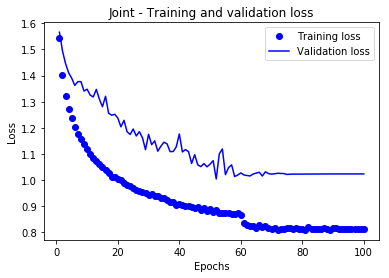

In [11]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Total Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Joint - Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

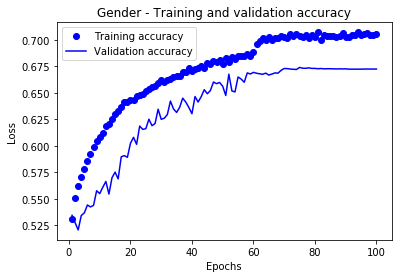

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(loss) + 1)
plt.subplots(1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Gender - Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# Do test predictions and compare performance with baseline
test = h5py.File('/data/music/musicnet/hdf5/test.hdf5', 'r')

list(test.keys())
test_data = test['data']
test_targets = test['targets']

In [14]:
test_predictions = model.predict(test_data)

In [15]:
test_predicted_labels = np.argmax(test_predictions, axis=1)
test_target_labels = np.argmax(test_targets, axis=1)

In [16]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
print('Accuracy ', accuracy_score(test_target_labels, test_predicted_labels))
print(classification_report(test_target_labels, test_predicted_labels))

Accuracy  0.6607142857142857
             precision    recall  f1-score   support

          0       0.72      0.79      0.76      1144
          1       0.67      0.89      0.77      6404
          2       0.62      0.35      0.45      1169
          3       0.69      0.50      0.58       274
          4       0.54      0.31      0.40       334
          5       0.66      0.50      0.57       211
          6       0.38      0.03      0.06       100
          7       0.48      0.32      0.39       961
          8       0.56      0.03      0.05       174
          9       0.63      0.28      0.38      1549

avg / total       0.64      0.66      0.63     12320



In [17]:
# Compare with baseline classifier (in this case we pick the most popular class)
most_popular = np.argmax(np.bincount(test_target_labels))

In [18]:
baseline_prediction = np.repeat(most_popular, test_target_labels.shape[0])

In [19]:
print('Accuracy ', accuracy_score(test_target_labels, baseline_prediction))
print(classification_report(test_target_labels, baseline_prediction))

Accuracy  0.5198051948051948
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1144
          1       0.52      1.00      0.68      6404
          2       0.00      0.00      0.00      1169
          3       0.00      0.00      0.00       274
          4       0.00      0.00      0.00       334
          5       0.00      0.00      0.00       211
          6       0.00      0.00      0.00       100
          7       0.00      0.00      0.00       961
          8       0.00      0.00      0.00       174
          9       0.00      0.00      0.00      1549

avg / total       0.27      0.52      0.36     12320



/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
# Compare with baseline classifier (predicting randomly based on popularity of each class)
unique, counts = np.unique(test_target_labels, return_counts=True)
props = counts / sum(counts)
random_predictions = np.random.choice(10, test_target_labels.shape[0], props.any())

In [21]:
print('Accuracy ', accuracy_score(test_target_labels, random_predictions))
print(classification_report(test_target_labels, random_predictions))

Accuracy  0.09545454545454546
             precision    recall  f1-score   support

          0       0.07      0.08      0.08      1144
          1       0.49      0.09      0.16      6404
          2       0.10      0.11      0.10      1169
          3       0.03      0.11      0.04       274
          4       0.03      0.09      0.04       334
          5       0.01      0.08      0.02       211
          6       0.01      0.10      0.02       100
          7       0.06      0.08      0.07       961
          8       0.02      0.11      0.03       174
          9       0.13      0.11      0.12      1549

avg / total       0.29      0.10      0.12     12320

